# BMEN 509 Project ABC-DISC

Details/Information


https://www.geeksforgeeks.org/python-blood-cell-identification-using-image-processing/

In [1]:
# Library Imports
import os
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from skimage import color
from scipy import signal, ndimage

# Setup Jupyter notebook specifics
%matplotlib inline

# Numpy printing help
np.set_printoptions(precision=2)

In [2]:
# Constants
data_directory = os.path.join('.', 'Data')
file_names = [
    'sample.png'
]

#Note this is image-4.png from the Kaggle data set available here: https://www.kaggle.com/draaslan/blood-cell-detection-dataset

In [3]:
# Verify we can find our files
for file_name in file_names:
    name = os.path.join(data_directory, file_name)
    if not os.path.isfile(name):
        os.sys.exit('Cannot find file {}. Please make sure you have downloaded the data'.format(name))
print('Found all image files!')

Found all image files!


In [4]:
# New Libary Imports
!python -m pip install opencv-python==4.1.2.30
import cv2

  Using cached https://files.pythonhosted.org/packages/c0/a9/9828dfaf93f40e190ebfb292141df6b7ea1a2d57b46263e757f52be8589f/opencv_python-4.1.2.30-cp36-cp36m-manylinux1_x86_64.whl


In [108]:
# Read & Load image
def Read_Img(name):
    filename = os.path.join(data_directory, name) 
    return cv2.imread(filename)

In [109]:
# Constrast stretching Function 
# Map each intensity level to an output intensity level
def pixelVal(pix, r1, s1, r2, s2): 
    if (0 <= pix and pix <= r1): 
        return (s1 / r1) * pix 
    elif (r1 < pix and pix <= r2): 
        return ((s2 - s1) / (r2 - r1)) * (pix - r1) + s1 
    else: 
        return ((255 - s2) / (255 - r2)) * (pix - r2) + s2 

In [117]:
# Enhance function plotting
# For testing purposes
def Enhance_Plots(image,gray,blurM,blurG,histoNorm,claheNorm,cs_all,cs_white,edge_all,edge_white):
    plt.subplots(1, 2, figsize=(10, 10))
    plt.subplot(121); plt.imshow(image); plt.title('Original Image')
    plt.subplot(122); plt.imshow(gray,cmap='gray'); plt.title('Gray Scaled Image')
    plt.show()
    
    plt.subplots(1,4,figsize=(20,20))
    plt.subplot(141); plt.imshow(blurM,cmap='gray'); plt.title('Median Filter/ blurM')
    plt.subplot(142); plt.imshow(blurG,cmap='gray'); plt.title('Guassian Filter / blurG')
    plt.subplot(143); plt.imshow(histoNorm,cmap='gray'); plt.title('Histogram Equalization')
    plt.subplot(144); plt.imshow(claheNorm,cmap='gray'); plt.title('Adaptive Histogram Equalization')
    plt.show()

    plt.subplots(1,2, figsize=(10,10))
    plt.subplot(121); plt.imshow(cs_all,cmap='gray'); plt.title('Contrast Stretch, All ')
    plt.subplot(122); plt.imshow(cs_white,cmap='gray'); plt.title('Contrast Stretch, White')
    plt.show()

    plt.subplots(1,2, figsize=(10,10))
    plt.subplot(121); plt.imshow(edge_all,cmap='gray'); plt.title('Edge Detection, All')
    plt.subplot(122); plt.imshow(edge_white,cmap='gray'); plt.title('Edge Detection, White')
    plt.show()

In [130]:
# Enhance Function
# Edge detection of image for all cells and white blood cells
def Enhance(file_name):
    # Reading in function
    image = Read_Img(file_name)
    # Convert to grey-scale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Histogram for analysis
    # Comment out whenever
    plt.hist(gray.ravel(), bins=256); plt.xlabel('Intensity'); plt.ylabel('Count')
    plt.title('Histogram of Grayscale Blood Cell Image with 256 Bins')
    plt.show()
    
     
    # Apply median filter for smoothning
    blurM = cv2.medianBlur(gray, 5)
    # Apply gaussian filter for smoothning
    blurG = cv2.GaussianBlur(blurM, (9, 9), 0)
    # Histogram equalization
    histoNorm = cv2.equalizeHist(blurG)
    # Contrast Limited Adaptive Histogram Equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize=(8, 8))
    claheNorm = clahe.apply(histoNorm)
    
    #Vectorize the Contrast Stretching function
    pixelVal_vec = np.vectorize(pixelVal) 
    
    # Apply contrast stretching
    # For all cells 
    con_str_all = pixelVal_vec(claheNorm, 120, 0, 140, 255)
    # For white blood cells
    con_str_white = pixelVal_vec(claheNorm, 0, 0, 25, 255)
    
    # Canny Edge Detection
    # For all cells
    edge_all = cv2.Canny( np.uint8(con_str_all*255) ,100,200)
    # For white cells
    edge_white = cv2.Canny( np.uint8(con_str_white*255) ,100,200)
    
    # Test Plotting
    # Comment out whenever
    """Enhance_Plots(image,gray,blurM,blurG,histoNorm,claheNorm,
                  con_str_all,con_str_white,edge_all,edge_white)
    """
    
    return edge_all,edge_white
    

In [190]:
# Detection function
# Detect cells according to edge detection
def Detect(img, name, T):
    
    # Test Plotting
    # Comment out whenever
    """plt.imshow(img, cmap='gray'); plt.title("Edge Detection for Circle Detection")
    plt.show()
    """
    # Morphological operations
    kernel = np.ones((5, 5), np.uint8) 
    dilation = cv2.dilate(img, kernel, iterations = 1) 
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel) 
    
    # Adaptive thresholding on mean and Gaussian filters
    th2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,\
                            cv2.THRESH_BINARY, 11, 2) 
    th3 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                            cv2.THRESH_BINARY, 11, 2) 
    
    # Otsu's thresholding
    ret4, th4 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Hough transform with modified circular parameters 
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1.2, 20,  
                 param1 = 50, param2 = 28, minRadius = 20, maxRadius = 40)

    # Read original image to display the circle and centre detection 
    filename = os.path.join(data_directory, name) 
    display = cv2.imread(filename) 
    # Initialize the list 
    Cell_count, x_count, y_count = [], [], [] 
    
    # Circle detection and labelling using Hough transformation
    if circles is not None: 
            # convert the (x, y) coordinates and radius of the circles to integers 
            #circles = np.round(circles[0, :]).astype("int")   
            circles = np.uint16(np.around(circles))
        
            # loop over the (x, y) coordinates and radius of the circles 
            # For (x, y, r) in circles[0,:]: 
            for i in circles[0,:]:
                    x = i[0];
                    y = i[1];
                    r = i[2];
                    cv2.circle(display, (x, y), r, (0, 255, 0), 2) 
                    cv2.rectangle(display, (x - 2, y - 2),  
                                  (x + 2, y + 2), (0, 128, 255), -1) 
                    Cell_count.append(r) 
                    x_count.append(x) 
                    y_count.append(y)
                    
    else: #No Cells detected
        if T==1: #For all cells
            print("ERROR: No cells were detected for All Cells")
        else: #For white blood cells
            print("ERROR: No cells were detected for White Blood Cells")
        return

    return display,len(Cell_count)


In [197]:
# All in one function, Name WIP
# Combines above function
def All_in_One(Name):
    #Edge detection for all cells and white blood cells
    edge_all,edge_white = Enhance(Name)
    
    #Cell Detection for All cells
    img_all, count_all = Detect(edge_all,Name,1)
    #Cell Detection for All cells
    img_white, count_white = Detect(edge_white,Name,0)

    plt.subplots(1,2, figsize=(10,10))
    plt.subplot(121); plt.imshow(cv2.cvtColor(img_all, cv2.COLOR_BGR2RGB)); plt.title("All Cell Detection")   
    plt.subplot(122); plt.imshow(cv2.cvtColor(img_white, cv2.COLOR_BGR2RGB)); plt.title("White Blood Cell Detection")
    plt.show()
    
    print("All Cell Count = \t{}".format(count_all))
    print("White Blood Cell Count = {}".format(count_white))
    print("Red Blood Cell Count = \t{}".format(count_all-count_white))

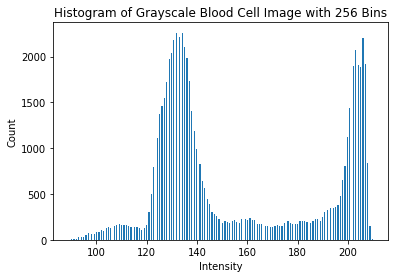

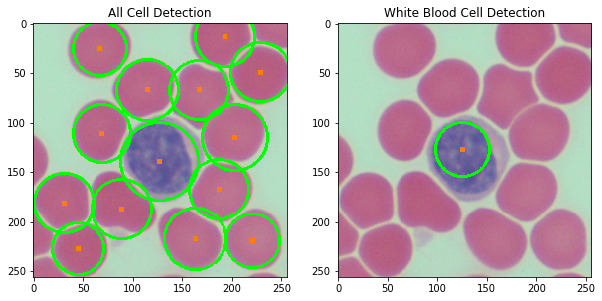

All Cell Count = 	14
White Blood Cell Count = 1
Red Blood Cell Count = 	13


In [198]:
Name = 'sample.png' 

"""
edge_all,edge_white = Enhance(Name)
img_all, count_all = Detect(edge_all,Name,1)
img_white, count_white = Detect(edge_white,Name,0)
"""

All_in_One(Name)


# Unused / Old / IDK what else to call this section

In [8]:
#Apply contrast stretching 
# contrast_stretched = pixelVal_vec(gray, r1, s1, r2, s2) 
# contrast_stretched_blurM = pixelVal_vec(blurM, r1, s1, r2, s2) 

# cv2.imwrite('contrast_stretch.png', contrast_stretched) 
# cv2.imwrite('contrast_stretch_blurM.png',  
#             contrast_stretched_blurM) 

In [9]:
#Edge detection using canny edge detector 
# edge = cv2.Canny(gray, 100, 200) 
# cv2.imwrite('edge.png', edge) 
  
# edgeG = cv2.Canny(blurG, 100, 200) 
# cv2.imwrite('edgeG.png', edgeG) 
  
# edgeM = cv2.Canny(blurM, 100, 200) 
# cv2.imwrite('edgeM.png', edgeM) 

In [110]:
#Vectorize the function to apply it to each value in the Numpy array
pixelVal_vec = np.vectorize(pixelVal) 

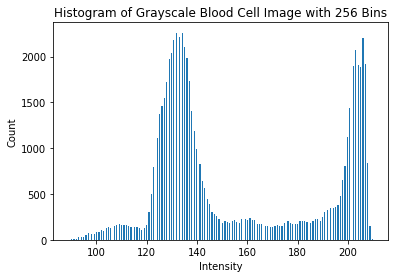

In [93]:
#Before, we saw the effect of applying each transformation to the original grayscale image
#Now let's try doing all the operations in sequence to obtain an enhanced image

#Convert to grayscale image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
#cv2.imwrite('gray.png', gray) 

#Plot the histogram of the image with 256 bins
plt.hist(gray.ravel(), bins=256); plt.xlabel('Intensity'); plt.ylabel('Count')
plt.title('Histogram of Grayscale Blood Cell Image with 256 Bins')
plt.show()

#Apply median filter for smoothing
blurM = cv2.medianBlur(gray, 5) 
#cv2.imwrite('blurM.png', blurM) 

#Apply Gaussian filter for smoothing
blurG = cv2.GaussianBlur(blurM, (9, 9), 0) 
#cv2.imwrite('blurG.png', blurG) 

#Histogram equalization
histoNorm = cv2.equalizeHist(blurG) 
#cv2.imwrite('histoNorm.png', histoNorm) 

#Contrast Limited Adaptive Histogram Equalization (CLAHE)
clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize=(8, 8)) 
claheNorm = clahe.apply(histoNorm) 
#cv2.imwrite('claheNorm.png', claheNorm) 

#Constrast stretching function has already been defined and vectorized

#Apply contrast stretching
contrast_stretched = pixelVal_vec(claheNorm, 120, 0, 140, 255)
contrast_stretched_Test = pixelVal_vec(claheNorm, 0, 0, 25, 255)

#Canny Edge Detection
edge = cv2.Canny( np.uint8(contrast_stretched*255) ,100,200)
edge_Test = cv2.Canny( blurM ,100,200) 


# Image Segmentation and Feature Extraction

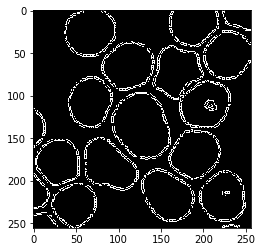

In [95]:
#Read enhanced image as grayscale, hence the flag set equal to 0
"""
File = edge
cv2.imwrite('Enhanced.png',File)
img = cv2.imread('Enhanced.png', 0)
"""
img = edge

plt.imshow(img, cmap='gray')
plt.show()

In [96]:
#Morphological operations
kernel = np.ones((5, 5), np.uint8) 
dilation = cv2.dilate(img, kernel, iterations = 1) 
closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel) 

In [97]:
#Adaptive thresholding on mean and Gaussian filters
th2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,\
                            cv2.THRESH_BINARY, 11, 2) 
th3 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                            cv2.THRESH_BINARY, 11, 2) 

In [98]:
#Otsu's thresholding
ret4, th4 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

In [99]:
#Hough transform with modified circular parameters 
#circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1.2, 20,  
#                           param1 = 50, param2 = 28, minRadius = 1, maxRadius = 20) 

# Test
circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1.2, 20,  
                 param1 = 50, param2 = 28, minRadius = 20, maxRadius = 40)



In [100]:
print(len(circles))

1


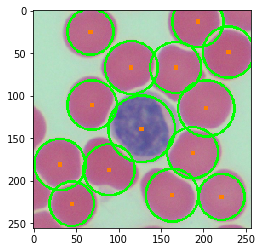

In [101]:
#Read original image to display the circle and centre detection   
display = cv2.imread(filename) 

# Initialize the list 
Cell_count, x_count, y_count = [], [], [] 

#Circle detection and labelling using Hough transformation
if circles is not None: 
        # convert the (x, y) coordinates and radius of the circles to integers 
        #circles = np.round(circles[0, :]).astype("int") 
        
        circles = np.uint16(np.around(circles))
        
        # loop over the (x, y) coordinates and radius of the circles 
        #for (x, y, r) in circles[0,:]: 
        for i in circles[0,:]:
                x = i[0];
                y = i[1];
                r = i[2];
                cv2.circle(display, (x, y), r, (0, 255, 0), 2) 
                cv2.rectangle(display, (x - 2, y - 2),  
                              (x + 2, y + 2), (0, 128, 255), -1) 
                Cell_count.append(r) 
                x_count.append(x) 
                y_count.append(y) 
        # show the output image 
#         cv2.imshow("gray", display) 
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()

#Imshow doesn't work for some reason so just save image to file instead
#cv2.imwrite('result.png', display)
plt.imshow(cv2.cvtColor(display, cv2.COLOR_BGR2RGB))
plt.show()

In [102]:
#Display the count of white blood cells  
print(len(Cell_count)) 

14


In [103]:
# Total number of radii
print(Cell_count) 

[27, 31, 30, 29, 30, 33, 27, 39, 26, 31, 30, 30, 30, 30]


In [104]:
#Coordinaes of circle
for i in range(len(Cell_count)):
    print('{}: ({},{})\tRadius={}'.format(i, x_count[i], y_count[i], Cell_count[i]) )

0: (221,219)	Radius=27
1: (115,67)	Radius=31
2: (187,167)	Radius=30
3: (69,111)	Radius=29
4: (31,181)	Radius=30
5: (203,115)	Radius=33
6: (67,25)	Radius=27
7: (127,139)	Radius=39
8: (45,227)	Radius=26
9: (163,217)	Radius=31
10: (167,67)	Radius=30
11: (89,187)	Radius=30
12: (229,49)	Radius=30
13: (193,13)	Radius=30


In [105]:
# #Circle detection and labelling using Hough transformation
# if circles is not None: 
#         # convert the (x, y) coordinates and radius of the circles to integers 
#         circles = np.round(circles[0, :]).astype("int") 
  
#         # loop over the (x, y) coordinates and radius of the circles 
#         for (x, y, r) in circles: 
  
#                 cv2.circle(display, (x, y), r, (0, 255, 0), 2) 
#                 cv2.rectangle(display, (x - 2, y - 2),  
#                               (x + 2, y + 2), (0, 128, 255), -1) 
#                 Cell_count.append(r) 
#                 x_count.append(x) 
#                 y_count.append(y) 
#         # show the output image 
#         cv2.imshow("gray", display) 
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()


In [106]:
#Parameters likely need to be changed for this dataset
#Read papers and CV2 documentation to better understand what's going on
#Check out OpenCV tutorials
#Google search: blood cell intensity threshold


# filename = os.path.join(data_directory, 'sample.png') #Read file and open image
# img_rgb = io.imread(filename) #Colour image
# img_gray = color.rgb2gray(img_rgb) #Grayscale image

# plt.figure(figsize = (16,8))
# plt.suptitle('Sample Blood Cell Image Taken Under a Microscope')

# plt.subplot(121)
# plt.imshow(img_rgb)
# plt.title('Colour')
# plt.xlabel('X')
# plt.ylabel('Y')

# plt.subplot(122)
# plt.imshow(img_gray, cmap='gray', vmin=0, vmax=1)
# plt.title('Grayscale')
# plt.xlabel('X')
# plt.ylabel('Y')

# plt.show()

In [107]:
#Need to double-check whether we actually need to convert to grayscale.
#Note there are many different conversion algorithms that apply different weightings.

#Useful links:
#https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
#https://stackoverflow.com/questions/3823752/display-image-as-grayscale-using-matplotlib
#https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python